In [1]:
%run common.ipy

Using DW in /home/davo/Documents/GRASIA/daostack-notebooks/datawarehouse from date 2023-05-01T00:00:00


DW version 1.1.9


dao-analyzer version: 1.2.6
cache-scripts version: 1.1.9


In [2]:
# Data tools
import pandas as pd
import numpy as np

# Visualization
from tqdm import tqdm
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

tqdm.pandas()

# Jupyter
import ipywidgets as widgets
from IPython.display import Markdown as Md

# Local modules
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport utils.plot

# Resumen

## ¿Cuantos votos se han emitido?

In [3]:
dfv = pd.read_feather(DAOSTACK.VOTES)
print(gbn := dfv['network'].value_counts())
print("Total:", total := len(dfv))
mainnet = gbn['mainnet']
xdai = gbn['xdai']

def pct(x, total):
    return f'{x/total*100:.2f}%'

Md(f"Se han emitido {total} votos, {mainnet} ({pct(mainnet,total)}) de ellos en mainnet, y {xdai} ({pct(xdai,total)}) en xdai")

xdai       12246
mainnet     7567
Name: network, dtype: int64
Total: 19813


Se han emitido 19813 votos, 7567 (38.19%) de ellos en mainnet, y 12246 (61.81%) en xdai

## ¿Cuantas personas han votado?

In [4]:
print("Total:", total:=dfv['voter'].nunique())
print(gbn:=dfv.groupby('network')['voter'].nunique())

mainnet = gbn['mainnet']
xdai = gbn['xdai']
both = mainnet + xdai - total

Md(f"{total} usuarios han votado, {mainnet} ({pct(mainnet,total)}) de ellos en mainnet y {xdai} ({pct(xdai,total)}) en xdai. Nótese que hay {both} ({pct(both,total)}) carteras que han votado en ambas.")

Total: 788
network
mainnet    448
xdai       396
Name: voter, dtype: int64


788 usuarios han votado, 448 (56.85%) de ellos en mainnet y 396 (50.25%) en xdai. Nótese que hay 56 (7.11%) carteras que han votado en ambas.

## Número medio de usuarios que votan en las propuestas

In [5]:
dfp = utils.get_df('dfp').dropna(subset=['votesForPct'])
# dfp

<AxesSubplot: xlabel='nvoters', ylabel='Density'>

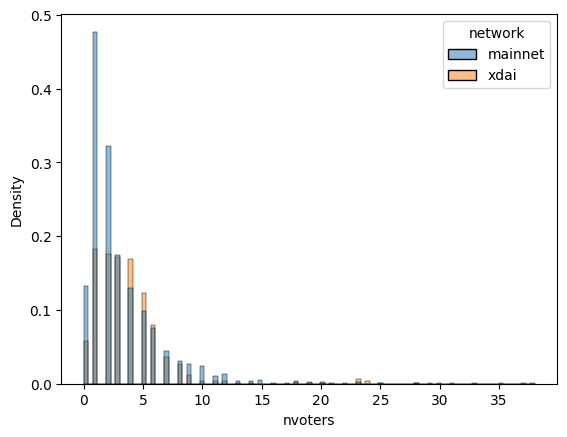

In [6]:
sns.histplot(dfp, x='nvoters', hue='network', stat='density')

## Voting power movilizado por red

Movilizado = no abstensión

In [7]:
dfp['movilizadoPct'] = dfp['votesForPct'] + dfp['votesAgainstPct']
assert ((0 <= dfp['movilizadoPct']) & (dfp['movilizadoPct'] <= 1.0)).all(), "All percentages should be smaller than 100%"

saving to ../logseq/assets/nb_figures/voting/movilizadoPct.png
Use ![](../assets/nb_figures/voting/movilizadoPct.png) to embed it in logseq


<AxesSubplot: xlabel='movilizadoPct', ylabel='Density'>

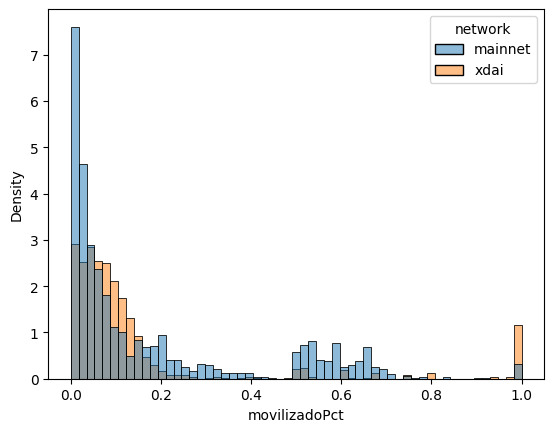

In [8]:
utils.plot.save_fig(sns.histplot(dfp, x='movilizadoPct', hue='network', stat='density'), "voting/movilizadoPct.png")

### Tabla de voting power movilizado

Debería quedar algo tal que así:

|    | mainnet | xdai |
|---|---|---|
| boosted | x% | y% |
| non-boosted | x'% | y'% |

In [9]:
dfp['boosted?'] = ~dfp.boostedAt.isna()

_table = dfp.groupby(['network', 'boosted?'])['movilizadoPct'].mean().unstack(level=0).applymap(lambda x: f'{x*100:.2f}%').sort_index(ascending=False)
utils.tables.save_table_image(_table, 'voting/voting_power_by_boosted.png', 'Voting power movilizado (boosted/non-boosted y network)')

saving to ../logseq/assets/nb_tables/voting/voting_power_by_boosted.png
/usr/bin/chromium


Use ![Voting power movilizado (boosted/non-boosted y network)](assets/nb_tables/voting/voting_power_by_boosted.png) to embed it in logseq


network,mainnet,xdai
boosted?,,
True,9.74%,8.39%
False,32.13%,47.45%


### Tabla de voting power movilizado según aprobadas y no

In [10]:
dfp.columns

Index(['proposer', 'stage', 'createdAt', 'preBoostedAt', 'boostedAt',
       'quietEndingPeriodBeganAt', 'closingAt', 'preBoostedClosingAt',
       'executedAt', 'totalRepWhenExecuted', 'totalRepWhenCreated',
       'executionState', 'expiresInQueueAt', 'votesFor', 'votesAgainst',
       'winningOutcome', 'stakesFor', 'stakesAgainst', 'title', 'description',
       'url', 'confidence', 'confidenceThreshold',
       'queuedVoteRequiredPercentage', 'queuedVotePeriodLimit',
       'boostedVotePeriodLimit', 'thresholdConst', 'minimumDaoBounty',
       'daoBountyConst', 'dao', 'competitionId', 'name', 'group',
       'originalName', 'votesForPct', 'votesAgainstPct', 'executedAtMonth',
       'createdAtMonth', 'daoRegister', 'nvoters', 'daostake', 'movilizadoPct',
       'boosted?'],
      dtype='object')

In [11]:
title = "Voting power movilizado por red según boosteadas y aprobadas o no"
dfp['approved?'] = dfp['winningOutcome'] == 'Pass'

_table = dfp.groupby(['network', 'boosted?', 'approved?'])['movilizadoPct'].mean().unstack(level=0).applymap(lambda x:f'{x*100:.2f}%').sort_index(ascending=False)
utils.tables.save_table_image(_table, 'voting/voting_power_by_boosted_approved.png', 'Voting power movilizado (boosted? y approved? vs. network)')

saving to ../logseq/assets/nb_tables/voting/voting_power_by_boosted_approved.png
/usr/bin/chromium


Use ![Voting power movilizado (boosted? y approved? vs. network)](assets/nb_tables/voting/voting_power_by_boosted_approved.png) to embed it in logseq


network            mainnet    xdai
boosted? approved?                
True     True        9.72%   8.39%
         False      10.10%   8.53%
False    True       60.58%  83.41%
         False       7.00%  10.09%

In [12]:
_table = dfp.groupby(['network', 'boosted?', 'approved?'])['movilizadoPct'].count().unstack(level=0).sort_index(ascending=False)
utils.tables.save_table_image(_table, 'voting/voting_power_boosted_approved_cnt.png', 'Número de casos de apoyo del voting power movilizado')

saving to ../logseq/assets/nb_tables/voting/voting_power_boosted_approved_cnt.png
/usr/bin/chromium


Use ![Número de casos de apoyo del voting power movilizado](assets/nb_tables/voting/voting_power_boosted_approved_cnt.png) to embed it in logseq


network             mainnet  xdai
boosted? approved?               
True     True          1482  1321
         False           42    18
False    True           395   133
         False          447   128

### Tabla de voting power medio movilizado por tipo de propuesta y red

Código copiado de [proposals.ipynb](./proposals.ipynb)

Index(['network', 'id', 'proposer', 'stage', 'createdAt', 'preBoostedAt',
       'boostedAt', 'quietEndingPeriodBeganAt', 'closingAt',
       'preBoostedClosingAt', 'executedAt', 'totalRepWhenExecuted',
       'totalRepWhenCreated', 'executionState', 'expiresInQueueAt', 'votesFor',
       'votesAgainst', 'winningOutcome', 'stakesFor', 'stakesAgainst', 'title',
       'description', 'url', 'confidence', 'confidenceThreshold',
       'queuedVoteRequiredPercentage', 'queuedVotePeriodLimit',
       'boostedVotePeriodLimit', 'thresholdConst', 'minimumDaoBounty',
       'daoBountyConst', 'dao', 'competitionId', 'name', 'group',
       'originalName', 'votesForPct', 'votesAgainstPct', 'executedAtMonth',
       'createdAtMonth', 'daoRegister', 'nvoters', 'daostake', 'stakes',
       'boosted', 'approved', 'votesPct'],
      dtype='object')


array([['\\textbf{9.7\\%}\n 9.6\\%\n0.1\\%',
        '\\textbf{60.7\\%}\n 60.7\\%\n0.0\\%'],
       ['\\textbf{10.6\\%}\n 3.0\\%\n7.6\\%',
        '\\textbf{7.2\\%}\n 2.2\\%\n5.0\\%']], dtype='<U29')

array([['\\textbf{8.4\\%}\n 8.3\\%\n0.0\\%',
        '\\textbf{60.8\\%}\n 60.8\\%\n0.0\\%'],
       ['\\textbf{9.0\\%}\n 2.2\\%\n6.8\\%',
        '\\textbf{5.5\\%}\n 1.5\\%\n4.0\\%']], dtype='<U29')

saving to ../logseq/assets/nb_figures/proposals/average_voting_power.png


Use ![Cantidad media de Voting Power ejercido en cada propuesta por red y tipo](../assets/nb_figures/proposals/average_voting_power.png) to embed it in logseq


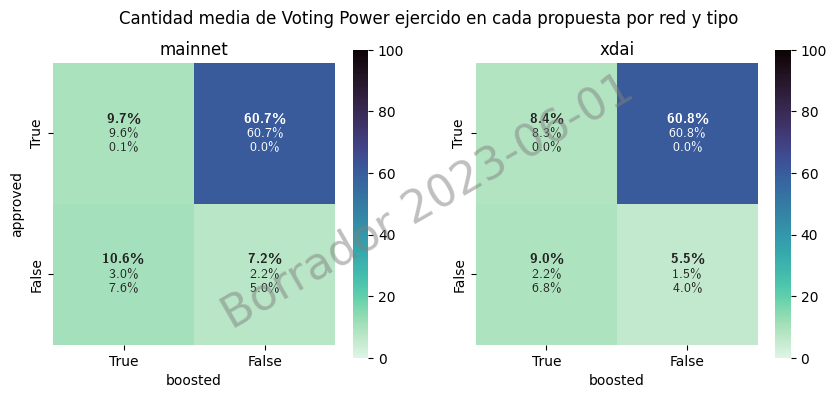

In [13]:
dfpr = utils.get_df('dfpr')

dfpr['votesPct'] = dfpr['votesForPct'] + dfpr['votesAgainstPct']
assert (~(dfpr['votesPct'] > 1)).any(), "Votes percentage should be bellow 100%"

print(dfpr.columns)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
fig.suptitle("Cantidad media de Voting Power ejercido en cada propuesta por red y tipo")
# fig.supxlabel("Red")

for i, n in enumerate(['mainnet', 'xdai']):    
    dfprn = dfpr[dfpr['network'] == n]
    
    ct = pd.crosstab(dfprn['approved'], dfprn['boosted'], values=dfprn['votesPct'], aggfunc='mean').sort_index(ascending=False).sort_index(axis=1, ascending=False)
    ctup = pd.crosstab(dfprn['approved'], dfprn['boosted'], values=dfprn['votesForPct'], aggfunc='mean').sort_index(ascending=False).sort_index(axis=1, ascending=False).to_numpy()
    ctdown = pd.crosstab(dfprn['approved'], dfprn['boosted'], values=dfprn['votesAgainstPct'], aggfunc='mean').sort_index(ascending=False).sort_index(axis=1, ascending=False).to_numpy()
    ct *= 100
    ctup *= 100
    ctdown *= 100
    # Hay que convertirlo a float porque es un Float
    ct = ct.astype(float)
    
    vlabel = np.vectorize(lambda up, down: f'\\textbf{{{up+down:.1f}\%}}\n {up:.1f}\%\n{down:.1f}\%')
        
    display(vlabel(ctup, ctdown))
    # total = ct.sum().sum()
    
    sns.heatmap(ct, 
                annot=vlabel(ctup, ctdown), fmt='', 
                ax=axs[i], 
                square=True,
                vmin=0, vmax=100,
                cmap=utils.plot.default_heatmap_cmap, 
                annot_kws={'usetex': True}
               )
    axs[i].set_title(n)
    
    if i != 0:
        axs[i].set_ylabel("")
        
utils.plot.save_fig(fig, 'proposals/average_voting_power.png')

### De las propuestas NANB, ¿cuantas tienen más a favor que en contra?

In [14]:
dfpr['boosted'].isna().any()

False

In [15]:
dfpr['relMaj'] = dfpr['votesFor'] > dfpr['votesAgainst']

# nanb: non approved, non boosted
msk = ~dfpr['approved'] & ~dfpr['boosted']
nanb = dfpr[msk]

print(vc := nanb.groupby('network')['relMaj'].value_counts())
vc / vc.groupby('network').sum() * 100

network  relMaj
mainnet  False     358
         True       71
xdai     False      85
         True       11
Name: relMaj, dtype: int64


network  relMaj
mainnet  False     83.449883
         True      16.550117
xdai     False     88.541667
         True      11.458333
Name: relMaj, dtype: float64

## % usuarios movilizado por red

In [16]:
dfd = utils.get_df('dfd')

In [17]:
# Nota: Como en general no hay mucha variación, aproximamos totalMembersWhenExecuted al número total de miembros históricos
dfp['totalMembersWhenExecuted'] = dfp.merge(dfd.reset_index()[['dao', 'hnusers']], how='left', on='dao')['hnusers'].to_numpy()
dfp['votersPct'] = dfp['nvoters'] / dfp['totalMembersWhenExecuted']

_table = dfp.groupby(['network', 'boosted?'])['votersPct'].mean().unstack(level=0).applymap(lambda x: f'{x*100:.2f}%').sort_index(ascending=False)
utils.tables.save_table_image(_table, 'voting/members_by_boosted.png', '% de miembros que participan')

saving to ../logseq/assets/nb_tables/voting/members_by_boosted.png
/usr/bin/chromium


Use ![% de miembros que participan](assets/nb_tables/voting/members_by_boosted.png) to embed it in logseq


network,mainnet,xdai
boosted?,,
True,2.43%,1.02%
False,8.06%,34.67%


In [18]:
_table = dfp.groupby(['network', 'boosted?', 'approved?'])['votersPct'].mean().unstack(level=0).applymap(lambda x: f'{x*100:.2f}%').sort_index(ascending=False)
utils.tables.save_table_image(_table, 'voting/members_boosted_approved.png', '% de miembros que participan por boosted y aprobada')

saving to ../logseq/assets/nb_tables/voting/members_boosted_approved.png
/usr/bin/chromium


Use ![% de miembros que participan por boosted y aprobada](assets/nb_tables/voting/members_boosted_approved.png) to embed it in logseq


network            mainnet    xdai
boosted? approved?                
True     True        2.39%   1.02%
         False       3.63%   0.97%
False    True       14.34%  59.81%
         False       2.51%   8.55%

# Comportamiento por DAOs

In [19]:
dfp.groupby(['network', 'dao'])['movilizadoPct'].describe()

count  unique       top  \
network dao                                                                   
mainnet 0x0b93ba560283350d4216f29dc57e15df38d0eace   49.0    47.0  0.000000   
        0x15344ecdc2c4edfcb092e284d93c20f0529fd8a6  127.0    64.0  0.193642   
        0x273d0f686a53a49a0fba2a801566b19f9aaf8fcd   37.0    11.0  0.000000   
        0x294f999356ed03347c7a23bcbcf8d33fa41dc830  387.0   355.0  0.000000   
        0x2b8c70fffda7f3d7667f7cfede1429313886329c   19.0    17.0  0.000000   
...                                                   ...     ...       ...   
xdai    0xeed417f80cd918ce65b8e141daa00704aef98a90    1.0     1.0  1.000000   
        0xef25b64d4bdbe23f1bb5e557b5d24f12c46da0bc    6.0     1.0  1.000000   
        0xf902172bd2f34a6cf86d424f0440836d2d89afeb    3.0     1.0  1.000000   
        0xfa19f292b400579794e2e3cc0d4b6559482b9d94    4.0     1.0  0.000000   
        0xfd4a08ba1863718d92467ad05f13b352c3ae2cfd    1.0     1.0  1.000000   

                                                    freq  
network dao                                               
mainnet 0x0b93ba560283350d4216f29dc57e15df38d0eace   2.0  
        0x15344ecdc2c4edfcb092e284d93c20f0529fd8a6  15.0  
        0x273d0f686a53a49a0fba2a801566b19f9aaf8fcd   8.0  
        0x294f999356ed03347c7a23bcbcf8d33fa41dc830  32.0  
        0x2b8c70fffda7f3d7667f7cfede1429313886329c   3.0  
...                                                  ...  
xdai    0xeed417f80cd918ce65b8e141daa00704aef98a90   1.0  
        0xef25b64d4bdbe23f1bb5e557b5d24f12c46da0bc   6.0  
        0xf902172bd2f34a6cf86d424f0440836d2d89afeb   3.0  
        0xfa19f292b400579794e2e3cc0d4b6559482b9d94   4.0  
        0xfd4a08ba1863718d92467ad05f13b352c3ae2cfd   1.0  

[66 rows x 4 columns]